In [2]:
#@title Boilerplate imports {display-mode: "form"}

# This code will be hidden when the notebook is loaded.
%matplotlib inline
!pip install stargazer
from stargazer.stargazer import Stargazer
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import scipy.stats
import statsmodels.stats.power as power
import statsmodels.formula.api as sfa
from functools import partial
import matplotlib.pyplot as plt
from IPython.display import display, HTML
plt.rcParams.update({
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "black",
    "axes.facecolor": "white",
    "axes.edgecolor": "lightgray",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "lightgray",
    "figure.facecolor": "black",
    "figure.edgecolor": "black",
    "savefig.facecolor": "black",
    "savefig.edgecolor": "black"})

np.random.seed(94115)

# Practical sources of bias in experiments

This notebook has identification analyses of three cases:
- Bias case 1: Adjusting randomization proportions during experiment
- Bias case 2: Non-compliance and "exposure" to treatment
- Bias case 3: Charitability influences viewing probability *and treatment effect*




# Bias case 1: Adjusting randomization proportions during experiment

This example demonstrates a real problem that can easily happen in a software environment. Experiments (A/B tests) on websites are often implemented with a **feature flag**, which in a binary "switch" in the code that causes the visitor to see one of two version of the site. Feature flags can be set to show the treatment version "randomly" to a specific percentage of the visitors. It is easy to adjust the percentage. But, changing the percentage can easily bias your experiment if the analysis does not account for this.

So far we have only considered experiments where the probability of treatment $P(D=1)$ is fixed and constant across all units. However, in some cases there may be reasons to change $P(D=1)$ during the experiment. In other words we would have a function $p(t) = P_t(D=1)$ where $t$ is the time that the unit is assigned to treatment. That can cause biased estimates of the treatment effect **even though the treatment is assigned "randomly"**! However, we will see that we may be able to adjust our analysis to remove the bias.

We are back in the world of **identification** so we will use very large data sets as an approximation to "infinite" data.

The first function below `generate_one_experiment` generates data from a simulated experiment. (Although remember that no real data set can actually have both $Y^1$ and $Y^0$ for any given unit!) This experiment will involve visitors to a charity website. The treatment is a redesign of some messages on the site, which we hope will increase the probability that a user donates. We will call this "conversion."

The data-generating process of the experiment has these key characteristics:

- On average 100,000 users visit the site each day. The number of visitors does not depend on the day of the week (note: unrealistic, simplifying assumption). **However**, the conversion rate does depend on the day of the week. Weekdays have a conversion rate of 0.30 while on weekends it is 0.10.
- We decide to run an experiment for 14 days which we number from 0,...,13.
- Day 0 is a Monday, and we started the experiment with a random 5 percent of users seeing the new site. We started with a low percentage to be cautious of possible negative effects of the change. The experiment ran at 5 percent through the end of Day 4: Friday of the first week.
- At the end of Friday we checked the results and saw a positive effect from the treatment. Feeling comfortable we decided to get more data by changing to a 50/50 split at the start of Day 5 (Saturday). We know from our previous exercises we will get more power with a 50/50 split!
- On Monday morning we come back and check the results again. Shock! There is a huge negative effect from the new site! 
- Unsure which results to believe and sticking to our original plan, we let the experiment run for the originally planned 2 weeks.
- At the end of 2 weeks we check the results and see a slight negative effect from the treatment.
- What happened?

*Note: The results we see will be abnormally stable because we have assumed relatively large "effects" and have a very large (approximately infinite) sample size. We can view this exercise as a stylized experiment designed to demonstrate a specific bias.*

In [3]:
def generate_one_experiment():
  # Average number of users of the site per day
  avg_N_per_day = 100000

  # Set experiment to last for 14 days
  length_of_experiment = 14
  dates = np.arange(0, length_of_experiment)

  # This function causes our treatment percentage to go from 5% to 50%.
  def treatment_percent(date):
    if date <= 4:
      return 0.05
    else:
      return 0.50

  # Conversion on the weekend is 20 pp lower.
  def daily_conversion_rates(day_of_week):
    if day_of_week in [5, 6]:
      return 0.10
    else:
      return 0.30

  # Determine the number of units on each day (use a Poisson distribution for convenience).
  N_each_day = np.random.poisson(avg_N_per_day, size=length_of_experiment)

  # Generate a row for each unit determined in the previous step.
  dates_of_units = np.concatenate(
      [dates[ii] * np.ones(shape=N) for ii, N in np.ndenumerate(N_each_day)]
  )

  # Make a dataframe tracking the date on which each unit visited the site
  # and the day of the week.
  df = pd.DataFrame({
      'date': dates_of_units.astype('int'),
      'day_of_week': np.mod(dates_of_units, 7).astype('int8')
  })
  # Number the units from 0 through N.
  # We assume that each unit is a distinct individual human.
  df['unit'] = df.index.values

  # The true ATE is 0.03, that is, the new site increases the probability 
  # of donation by 0.03.
  ATE = 0.03
  p_y0 = df['day_of_week'].apply(daily_conversion_rates)
  df['y0'] = np.random.binomial(n=1, p=p_y0).astype('int8')
  df['y1'] = np.random.binomial(n=1, p=p_y0 + ATE).astype('int8')

  # Apply the function that determines the percentage treated on each day.
  df['treatment_percent_by_day'] = df['date'].apply(treatment_percent)
  df['d'] = np.random.binomial(n=1, p=df['treatment_percent_by_day']).astype('int8')
  df['y'] = df.eval("d * y1 + (1 - d) * y0")

  df['hour_of_day'] = np.random.randint(1, 24, size=df.shape[0])

  return df

In [4]:
avg_N_per_day = 100000

# Set experiment to last for 14 days
length_of_experiment = 14
dates = np.arange(0, length_of_experiment)

# This function causes our treatment percentage to go from 5% to 50%.
def treatment_percent(date):
  if date <= 4:
    return 0.05
  else:
    return 0.50

# Conversion on the weekend is 20 pp lower.
def daily_conversion_rates(day_of_week):
  if day_of_week in [5, 6]:
    return 0.10
  else:
    return 0.30

# Determine the number of units on each day (use a Poisson distribution for convenience).
N_each_day = np.random.poisson(avg_N_per_day, size=length_of_experiment)

# Generate a row for each unit determined in the previous step.
dates_of_units = np.concatenate(
    [dates[ii] * np.ones(shape=N) for ii, N in np.ndenumerate(N_each_day)]
)


## Basic description of the data

### Distribution of treatment/control each day

First, let's graph the total users each day, split by treatment vs. control. We see what we expected, in the first 5 days about ~5 percent of users are in the treatment group. After that we have about 50% of users in the treatment group on each day.

### Daily conversion rates

We also plot the conversion rates each day. As we had specified in the data generating process, on weekdays the conversion rate is about 0.30, but on weekends the conversion rate drops to about 0.10. When we compare treatment and control, the results are again as we expect. The treatment conversion rate is about 0.03 higher![link text](https://)

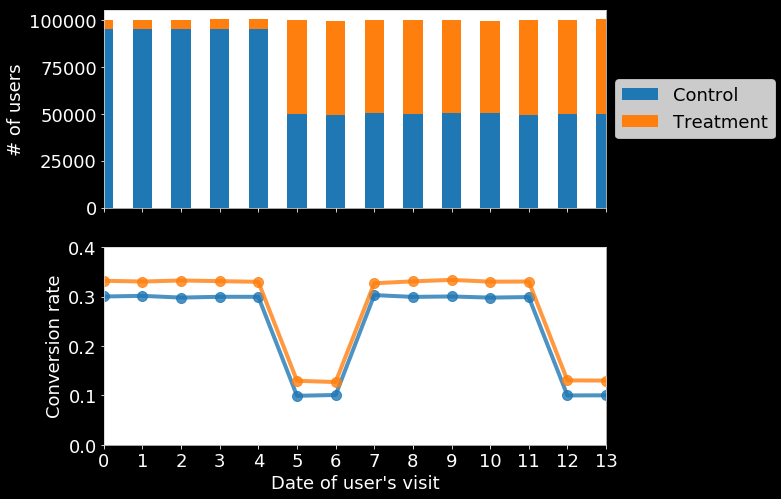

In [5]:
df = generate_one_experiment()
f, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(9, 8))
df.groupby(['date', 'd'])['unit'].count().unstack(-1) \
  .rename(columns={0: 'Control', 1: 'Treatment'}) \
  .plot(ax=axs[0], kind='bar', stacked=True, rot=0)
axs[0].set_ylabel("# of users", fontsize=18)
axs[0].set_xlabel("Date of user's visit", fontsize=18)
axs[0].tick_params(labelsize=18)
axs[0].legend(fontsize=18, loc='center left', bbox_to_anchor=(1, 0.5))

df.groupby(['date', 'd'])['y'].mean().unstack(-1) \
  .rename(columns={0: 'Control', 1: 'Treatment'}) \
  .plot(ax=axs[1], kind='line', marker='o', linewidth=4, markersize=10, alpha=0.8, legend=False)
axs[1].set_ylabel("Conversion rate", fontsize=18)
axs[1].set_xlabel("Date of user's visit", fontsize=18)
axs[1].tick_params(labelsize=18)
axs[1].set_ylim(0, 0.4);

## Naive (and biased) approach to estimating the average treatment effect (ATE)

Below we calculate the simple difference in conversion rates between the treatment and control groups. That difference estimates the NATE, but this gives us a biased estimate of the ATE.

Suppose that we eagerly check the results on the first Friday after we start the experiment and then again on Monday morning after the weekend. Finally, we check the results again at the end of the experiment. The results are in the figure "Results from simulated experiment."

On Friday evening our results tell us the treatment effect is about a 3 percentage point increase in conversion, which is close to the true ATE. However, on Monday morning we see nearly a 10 percent point **decrease** from the treatment. Finally, at the end of the experiment, the estimated treatment effect is about -0.01.

To investigate in more detail, let's look at the figure "Daily checks of experiment results." It shows what happens to the naively estimated treatment effect when we check it _every day_. The graph shows that the estimate starts out stable near the true ATE. However, during the first weekend it drops to a very low level before slowly growing during the second week. However, during the second weekend it starts to dip again before ending at a negative estimate.

### Why is the estimate moving over time in this way?

Intuitively, the reason for this is that we have stacked the treatment group with a large proportion of low-conversion-rate users from the weekend.

To start understanding why this is happening look at the plot "What proportion of the group was collected on weekends"? That plot shows that over the course of the experiment there large changes in the proportion of *weekend users* in the treatment group. At the end of the first weekend, about 80 percent of the treatment group was collected over the weekend. But only about 20 percent of the control group was collected over the weekend. The difference appears because on Friday we moved from 5% treatment to 50% treatment. 

At the end of the experiment, we can compare each group. This is in the figure "Day-of-week distribution of users in each group". We can see that the treatment group has substantially more Saturday and Sunday users.

### How can we understand this in terms of causal inference?

This problem is a form of *selection bias* introduced by changing the randomization proportion during the experiment.

We can see this in the plot "Average baseline outcome in each group". The baseline outcome $E[Y^0]$, the conversion rate without any treatment, is substantially lower in the treatment group. This is exactly selection bias. 

To see how we remove the selection bias, continue to the next section on perfect stratification.


In [6]:
# This function just estimates the NATE by taking the difference in rates.
def estimate_nate(df):
  means = df.groupby('d')['y'].mean()
  return means[1] - means[0]

# This function estimates the NATE on Friday, Monday, and the end of the experiment.
def check_experiment_results(df):
  return {
      'estimate_01_on_end_of_friday': estimate_nate(df.query("date <= 4")),
      'estimate_02_on_monday_morning': estimate_nate(df.query("date <= 6")),
      'estimate_03_end_of_experiment': estimate_nate(df),
  }

,Results @ Friday (end of day),Results @ Monday (start of day),Results @ End of experiment
d,,,
0,0.299672,0.265157,0.256689
1,0.331139,0.168459,0.245516


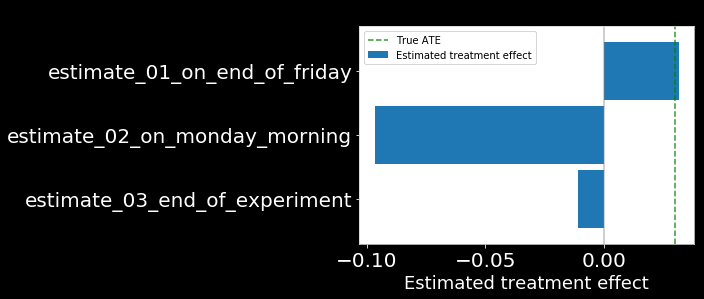

In [7]:
staged_results = df.query("date <= 4").groupby('d')['y'].mean().to_frame('Results @ Friday (end of day)') \
  .join(df.query("date <= 6").groupby('d')['y'].mean().to_frame("Results @ Monday (start of day)")) \
  .join(df.groupby('d')['y'].mean().to_frame('Results @ End of experiment'))

display(staged_results)

data_to_plot = pd.DataFrame([check_experiment_results(df)]).T.sort_index(ascending=False)
data_to_plot.columns = ['Estimated treatment effect']
ax = data_to_plot.plot(kind='barh', figsize=(6, 4), legend=False, width=0.9)
ax.set_title("Results from simulated experiment", fontsize=18)
ax.axvline(0, alpha=0.5, color='grey')
ax.tick_params(labelsize=20)
ax.set_xlabel("Estimated treatment effect", fontsize=18)
# Plot the true ATE
ax.axvline(0.03, alpha=0.8, color='green', linestyle='--', label='True ATE')
ax.legend();

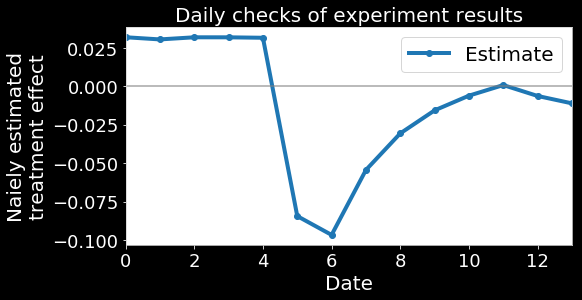

In [8]:
daily_results = pd.DataFrame(
    [{'date': dd, 'Estimate': estimate_nate(df.query("date<=@dd"))} for dd in df['date'].unique()]
)
ax = daily_results.set_index('date').plot(figsize=(8, 4), linewidth=4, marker='o')
ax.tick_params(labelsize=18)
ax.set_xlabel("Date", fontsize=20)
ax.set_ylabel("Naiely estimated\ntreatment effect", fontsize=20)
ax.axhline(0, color='grey', alpha=0.7)
ax.set_title("Daily checks of experiment results", fontsize=20, color='white')
ax.legend(fontsize=20);

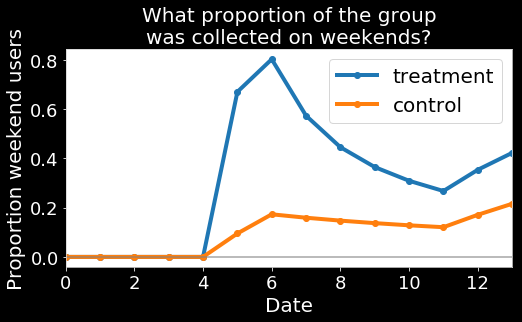

In [9]:
daily_percent_from_weekend = pd.DataFrame([
      {
      'date': dd,
      'treatment': df.query("date<=@dd and d==1").eval("day_of_week in [5, 6]").mean(),
      'control': df.query("date<=@dd and d==0").eval("day_of_week in [5, 6]").mean(),
      } for dd in df['date'].unique()
])
ax = daily_percent_from_weekend.set_index('date').plot(figsize=(8, 4), linewidth=4, marker='o')
ax.tick_params(labelsize=18)
ax.set_xlabel("Date", fontsize=20)
ax.set_ylabel("Proportion weekend users", fontsize=20)
ax.axhline(0, color='grey', alpha=0.7)
ax.set_title("What proportion of the group\nwas collected on weekends?", fontsize=20, color='white')
ax.legend(fontsize=20);

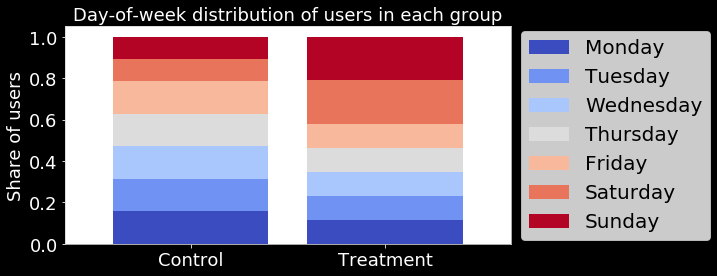

In [10]:
data_to_plot = df.groupby(['day_of_week', 'd'])['unit'].count().unstack(0) 
data_to_plot = data_to_plot.divide(data_to_plot.sum(axis=1), axis=0)

ax = data_to_plot.rename(index={0: 'Control', 1: 'Treatment'},
                        columns={0: 'Monday', 1: 'Tuesday', 2: "Wednesday", 3: 'Thursday', 4: "Friday", 5: 'Saturday', 6: 'Sunday'}) \
  .plot(kind='bar', stacked=True, figsize=(8, 4), colormap='coolwarm', rot=0, width=0.8)
ax.set_ylabel("Share of users", fontsize=18)
ax.set_xlabel("")
ax.tick_params(labelsize=18)
ax.set_title("Day-of-week distribution of users in each group", fontsize=18, color='white')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=20);


d
0    0.256689
1    0.217279
Name: y0, dtype: float64


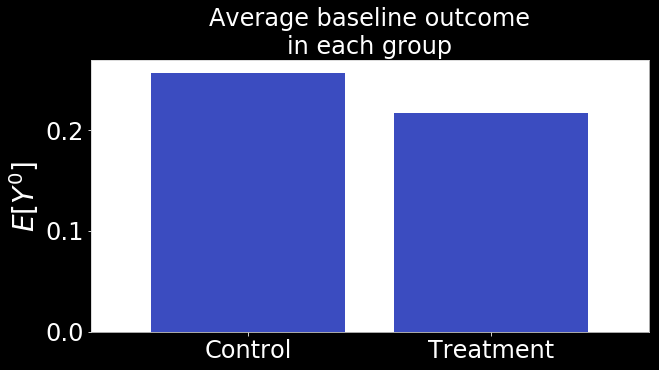

In [16]:
data_to_plot = df.groupby(['d'])['y0'].mean()
print(data_to_plot)
ax = data_to_plot.rename(index={0: 'Control', 1: 'Treatment'}) \
  .plot(kind='bar', figsize=(10, 5), colormap='coolwarm', legend=False, width=0.8, rot=0)
ax.set_ylabel(r"$E[Y^0]$", fontsize=28, rotation=90)
ax.set_xlabel("", fontsize=24)
ax.set_title("Average baseline outcome\nin each group", fontsize=24, color="white")
ax.tick_params(labelsize=24);

## Removing the selection bias via perfect stratification

We will use a **perfect stratification** to remove bias. This means that we will stratify the data into several subgroups (strata). "Perfect" means that we can put each person in the experiment into exactly the right group such that all selection bias is accounted for. 

With the data split into several strata, we will get a separate estimate of the ATE within each one. Then we will average together the estimates of each of the strata.

Note that this approach *sometimes* removes bias. The key condition is that we know what the **strata** (or groups) in the data account for the bias. This means we need to know conceptually what they are and have data on the strata. In this case, we do have these! We know that the date determines the randomization proportions.

For a detailed discussion of stratification, see chapter 4 (especially section 2) of Morgan and Winship, _Counterfactuals and Causal Inference_ (2007), which is available as a PDF from the USF library.

The stratification approach relies on an alternative to the _independence assumption_. It is the _conditional (mean) independence assumption_, $$E[Y_i^t \vert D_i, X_i = x] = E[Y_i^t \vert X_i = x_i]$$

for each potential outcome $t=0,1$ and all strata $x_i$. Another way to say this is that the (mean) independence assumption holds within each stratum. In this example case the strata could be the date, so $x_i \in \{0, 1, 2, \ldots, 13\}$.


In [12]:
# Calculate an estimate of the ATE for each day of the week.
STRATA_VARIABLE = 'date'
conversion_rates_by_strata = df.groupby([STRATA_VARIABLE, 'd'])['y'].mean().unstack(-1)
conversion_rates_by_strata.columns = ['control', 'treatment']
conversion_rates_by_strata['difference'] = conversion_rates_by_strata.eval("treatment - control")

# Calculate the number of units in each stratum
counts_by_strata = df.groupby([STRATA_VARIABLE])['y'].count()

conversion_rates_by_strata['counts'] = counts_by_strata

display(conversion_rates_by_strata)

# Calculate the *weighted-average* of the estimates.
# Note that in this very simple case we would get an unbiased estimate even
# if we did not weight the average. However, the weighted average has two advantages:
# (1) it gives a more precise estimate and a test with more power, and (2)
# if the treatment effects vary by strata it is still unbiased for the ATE.
print("\nEstimate of ATE (perfect stratification) = {:.5f}".format(
      (conversion_rates_by_strata.eval("difference * counts").sum() / conversion_rates_by_strata['counts'].sum()))
)

,control,treatment,difference,counts
date,,,,
0,0.300099,0.331908,0.031809,100203
1,0.301405,0.330396,0.028992,100112
2,0.297899,0.332450,0.034551,100133
3,0.299512,0.331206,0.031695,100240
4,0.299449,0.329753,0.030304,100326
5,0.099208,0.129531,0.030323,100207
6,0.100776,0.126991,0.026216,99523
7,0.302915,0.326871,0.023956,100172
8,0.299308,0.330724,0.031416,100220



Estimate of ATE (perfect stratification) = 0.03048


# Modify the “perfect stratification" analysis, which uses the date of visit to stratify. If we stratify by the day of the week, do we get an unbiased estimate of the ATE? Why does this work?

In [24]:
# Calculate an estimate of the ATE for each day of the week.
STRATA_VARIABLE = 'day_of_week'
conversion_rates_by_strata = df.groupby([STRATA_VARIABLE, 'd'])['y'].mean().unstack(-1)
conversion_rates_by_strata.columns = ['control', 'treatment']
conversion_rates_by_strata['difference'] = conversion_rates_by_strata.eval("treatment - control")

# Calculate the number of units in each stratum
counts_by_strata = df.groupby([STRATA_VARIABLE])['y'].count()

conversion_rates_by_strata['counts'] = counts_by_strata

display(conversion_rates_by_strata)

# Calculate the *weighted-average* of the estimates.
# Note that in this very simple case we would get an unbiased estimate even
# if we did not weight the average. However, the weighted average has two advantages:
# (1) it gives a more precise estimate and a test with more power, and (2)
# if the treatment effects vary by strata it is still unbiased for the ATE.
print("\nEstimate of ATE (perfect stratification) = {:.5f}".format(
      (conversion_rates_by_strata.eval("difference * counts").sum() / conversion_rates_by_strata['counts'].sum()))
)

,control,treatment,difference,counts
day_of_week,,,,
0,0.301070,0.327322,0.026252,200375
1,0.300682,0.330695,0.030012,200332
2,0.298687,0.333607,0.034921,200154
3,0.298941,0.330199,0.031258,199925
4,0.299283,0.330293,0.031010,200040
5,0.099550,0.129907,0.030357,200192
6,0.100456,0.128512,0.028056,199781



Estimate of ATE (perfect stratification) = 0.03027


## Regression as a way to implement a stratification

Regression can be a convenient tool to implement a stratification. The example below shows we get the correct result by including a dummy variable for each day of the week. The estimate is also near identical to the one from the perfect stratification.

_Note that by specifying the regression this way, we have implicitly assumed that the ATE is the same within each strata. This assumption is a substantive one. It happens to hold in this example, but it is not always true. The regression approach can give a biased estimate in those cases._

For a discussion of regression and stratification, see chapter 5 (especially section 1) of Morgan and Winship, _Counterfactuals and Causal Inference_ (2007).

In [13]:
# Compute a regression of the outcome on the treatment indicator
# and dummy variables for each date.
# Use HC1 standard error estimator because binary dependent variable!
r = sfa.ols("y ~ d + C(date)", df).fit(cov_type='HC1')

print("Estimate of ATE = {:.5f}".format(r.params['d']))
print(r.summary(yname="Conversion"))

/home/aboli/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


Estimate of ATE = 0.03007
                            OLS Regression Results                            
Dep. Variable:             Conversion   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     5891.
Date:                Sat, 22 Feb 2020   Prob (F-statistic):               0.00
Time:                        15:02:48   Log-Likelihood:            -7.9089e+05
No. Observations:             1400799   AIC:                         1.582e+06
Df Residuals:                 1400784   BIC:                         1.582e+06
Df Model:                          14                                         
Covariance Type:                  HC1                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.

# We can also use regression to implement a stratification. First, run a simple regression of Y on D and confirm that you get the same naive estimate of the ATE. Then add ‘day_of_week‘ as a control variable. You need to use the ‘C()‘ dummy variable operator. Show that this gives you an unbiased estimate.

In [29]:
# Compute a regression of the outcome on the treatment indicator
# and dummy variables for each date.
# Use HC1 standard error estimator because binary dependent variable!
r = sfa.ols("y ~ d + C(day_of_week)", df).fit(cov_type='HC1')

print("Estimate of ATE = {:.5f}".format(r.params['d']))
print(r.summary(yname="Conversion"))

Estimate of ATE = 0.03019
                            OLS Regression Results                            
Dep. Variable:             Conversion   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                 1.177e+04
Date:                Sat, 22 Feb 2020   Prob (F-statistic):               0.00
Time:                        16:10:47   Log-Likelihood:            -7.9090e+05
No. Observations:             1400799   AIC:                         1.582e+06
Df Residuals:                 1400791   BIC:                         1.582e+06
Df Model:                           7                                         
Covariance Type:                  HC1                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercep

In [25]:
r = sfa.ols("y ~ d", df).fit(cov_type='HC1')
print("Estimate of NATE = {:.5f}".format(r.params['d']))

Estimate of NATE = -0.01117


In [28]:
NATE = df.query('d == 1')['y1'].mean() - df.query('d == 0')['y0'].mean()
NATE

-0.011173061644001642

In [20]:
round(df['y1'].mean() - df['y0'].mean(),2)

0.03

# Note that the data set also has a field for ‘hour_of_day‘, which ranges over 1,2,3,...,24. This is the hour that the user visited the site. Does doing a perfect stratification analysis by the hour of the day give you an unbiased estimate of the ATE? Show and explain your answer.

In [31]:
r = sfa.ols("y ~ d + C(hour_of_day)", df).fit(cov_type='HC1')

print("Estimate of ATE = {:.5f}".format(r.params['d']))
print(r.summary(yname="Conversion"))

Estimate of ATE = -0.01117
                            OLS Regression Results                            
Dep. Variable:             Conversion   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     10.48
Date:                Sat, 22 Feb 2020   Prob (F-statistic):           3.07e-38
Time:                        17:54:58   Log-Likelihood:            -8.2044e+05
No. Observations:             1400799   AIC:                         1.641e+06
Df Residuals:                 1400775   BIC:                         1.641e+06
Df Model:                          23                                         
Covariance Type:                  HC1                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Inter

In [32]:
# Calculate an estimate of the ATE for each day of the week.
STRATA_VARIABLE = 'hour_of_day'
conversion_rates_by_strata = df.groupby([STRATA_VARIABLE, 'd'])['y'].mean().unstack(-1)
conversion_rates_by_strata.columns = ['control', 'treatment']
conversion_rates_by_strata['difference'] = conversion_rates_by_strata.eval("treatment - control")

# Calculate the number of units in each stratum
counts_by_strata = df.groupby([STRATA_VARIABLE])['y'].count()

conversion_rates_by_strata['counts'] = counts_by_strata

display(conversion_rates_by_strata)

# Calculate the *weighted-average* of the estimates.
# Note that in this very simple case we would get an unbiased estimate even
# if we did not weight the average. However, the weighted average has two advantages:
# (1) it gives a more precise estimate and a test with more power, and (2)
# if the treatment effects vary by strata it is still unbiased for the ATE.
print("\nEstimate of ATE (perfect stratification) = {:.5f}".format(
      (conversion_rates_by_strata.eval("difference * counts").sum() / conversion_rates_by_strata['counts'].sum()))
)

,control,treatment,difference,counts
hour_of_day,,,,
1,0.256202,0.248167,-0.008035,60946
2,0.257548,0.245752,-0.011796,60914
3,0.258780,0.240200,-0.018579,61001
4,0.257286,0.245275,-0.012011,60726
5,0.255323,0.249406,-0.005917,60594
6,0.256004,0.240294,-0.015710,61030
7,0.254987,0.243200,-0.011788,60828
8,0.260981,0.246604,-0.014377,60799
9,0.256202,0.248308,-0.007894,60644



Estimate of ATE (perfect stratification) = -0.01117


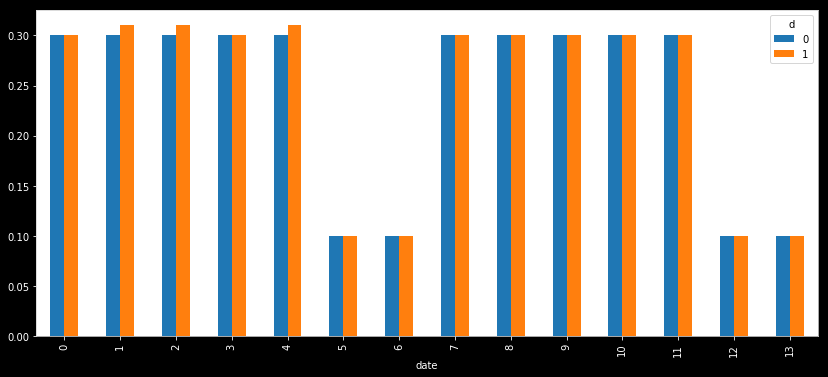

In [73]:
round(df.groupby(['d', 'date'])['y0'].mean(),2).unstack(0).plot(kind = 'bar', figsize = (14,6))

Text(0, 0.5, 'E[Y0]')

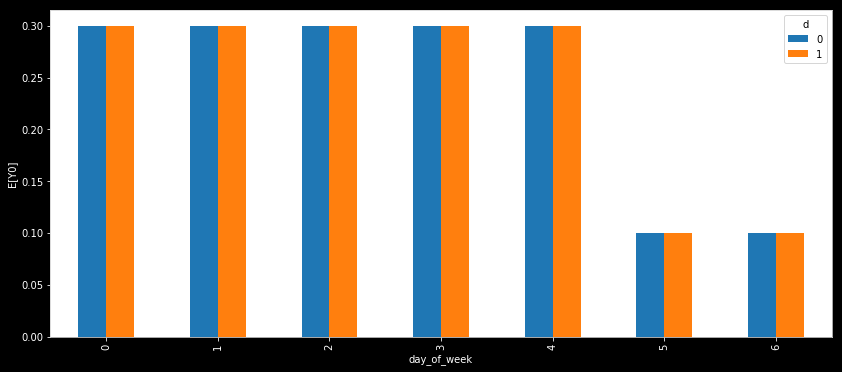

In [76]:
round(df.groupby(['d', 'day_of_week'])['y0'].mean(),2).unstack(0).plot(kind = 'bar', figsize = (14,6))
plt.ylabel('E[Y0]')

Text(0, 0.5, 'E[Y0]')

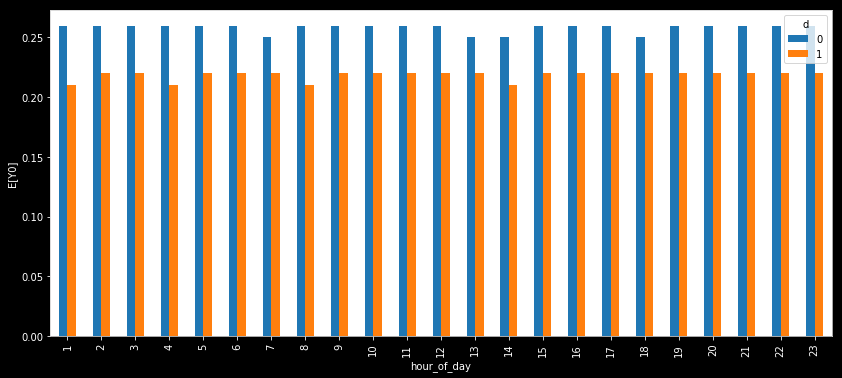

In [77]:
round(df.groupby(['d', 'hour_of_day'])['y0'].mean(),2).unstack(0).plot(kind = 'bar', figsize = (14,6))
plt.ylabel('E[Y0]')

### Modify the data-generating process so that the treatment effect also varies by the day of the week. Let’s imagine that since weekend visitors are less likely to convert they are generally less interested, so they also have a lower treatment effect. To make this very stark set the treatment effect to 0.005 on the weekend and 0.10 on weekdays. Implementing this in the DGP looks very similar to the conversion rate weekly cyclicality. You can adapt the function ‘daily_conversion_rates‘ and be sure to change the ‘ATE‘ variable from a constant to an array. Show these results: (i) Calculate the true ATE in the data, (ii) estimate the ATE using a regression with ‘day_of_week‘ dummy variables, and (iii) estimate the ATE using a perfect stratification on ‘day_of_week‘. Which of the two estimators gives an unbiased estimate? What did you learn from this?

In [80]:
def generate_one_experiment_varying_ATE():
  # Average number of users of the site per day
  avg_N_per_day = 100000

  # Set experiment to last for 14 days
  length_of_experiment = 14
  dates = np.arange(0, length_of_experiment)

  # This function causes our treatment percentage to go from 5% to 50%.
  def treatment_percent(date):
    if date <= 4:
      return 0.05
    else:
      return 0.50

  # Conversion on the weekend is 20 pp lower.
  def daily_conversion_rates(day_of_week):
    if day_of_week in [5, 6]:
      return 0.10
    else:
      return 0.30

  # Determine the number of units on each day (use a Poisson distribution for convenience).
  N_each_day = np.random.poisson(avg_N_per_day, size=length_of_experiment)

  # Generate a row for each unit determined in the previous step.
  dates_of_units = np.concatenate(
      [dates[ii] * np.ones(shape=N) for ii, N in np.ndenumerate(N_each_day)]
  )

  # Make a dataframe tracking the date on which each unit visited the site
  # and the day of the week.
  df = pd.DataFrame({
      'date': dates_of_units.astype('int'),
      'day_of_week': np.mod(dates_of_units, 7).astype('int8')
  })
  # Number the units from 0 through N.
  # We assume that each unit is a distinct individual human.
  df['unit'] = df.index.values

  def daily_ATE(day_of_week):
    if day_of_week in [5, 6]:
      return  0.005
    else:
      return 0.10

  p_y0 = df['day_of_week'].apply(daily_conversion_rates)
  ATE = df['day_of_week'].apply(daily_ATE)
  df['y0'] = np.random.binomial(n=1, p=p_y0).astype('int8')
  df['y1'] = np.random.binomial(n=1, p=p_y0 + ATE).astype('int8')

  # Apply the function that determines the percentage treated on each day.
  df['treatment_percent_by_day'] = df['date'].apply(treatment_percent)
  df['d'] = np.random.binomial(n=1, p=df['treatment_percent_by_day']).astype('int8')
  df['y'] = df.eval("d * y1 + (1 - d) * y0")

  df['hour_of_day'] = np.random.randint(1, 24, size=df.shape[0])

  return df

In [82]:
df = generate_one_experiment_varying_ATE()

In [85]:
r = sfa.ols("y ~ d", df).fit(cov_type='HC1')
print("Estimate of NATE = {:.5f}".format(r.params['d']))

Estimate of NATE = 0.01816


In [84]:
NATE = df.query('d == 1')['y1'].mean() - df.query('d == 0')['y0'].mean()
NATE

0.018158553000688804

In [93]:
ATE = (df['y1'] - df['y0']).mean()
ATE

0.07208771624172805

Text(0, 0.5, 'E[Y0]')

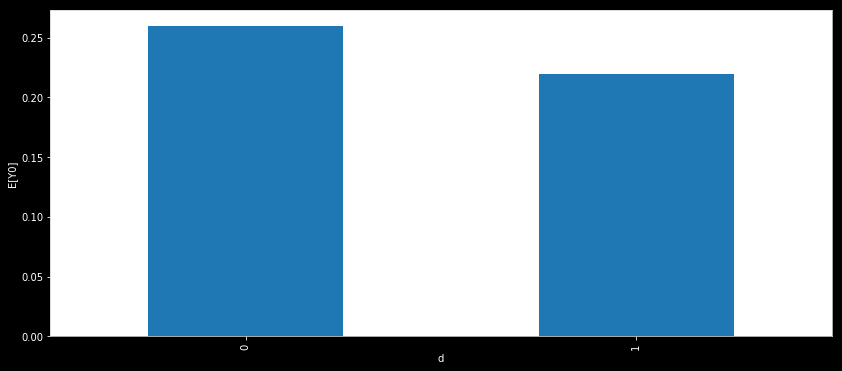

In [96]:
round(df.groupby('d')['y0'].mean(),2).plot(kind = 'bar', figsize = (14,6))
plt.ylabel('E[Y0]')

Text(0, 0.5, 'E[Y0]')

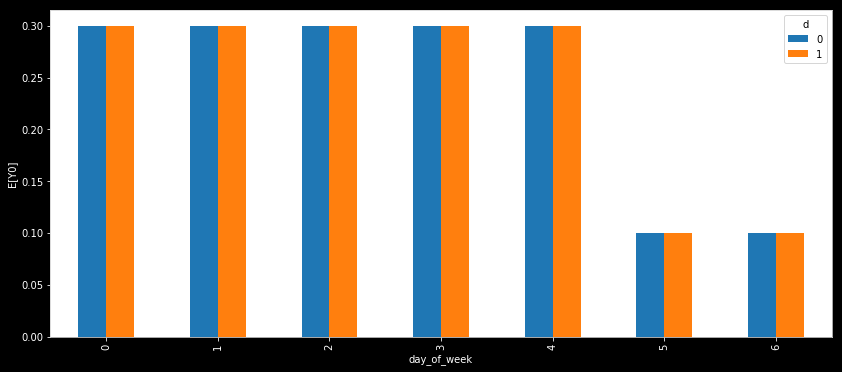

In [89]:
round(df.groupby(['d','day_of_week'])['y0'].mean(),2).unstack(0).plot(kind = 'bar', figsize = (14,6))
plt.ylabel('E[Y0]')

In [94]:
r = sfa.ols("y ~ d + C(day_of_week)", df).fit(cov_type='HC1')

print("Estimate of ATE = {:.5f}".format(r.params['d']))
print(r.summary(yname="Conversion"))

Estimate of ATE = 0.06719
                            OLS Regression Results                            
Dep. Variable:             Conversion   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                 1.679e+04
Date:                Sat, 22 Feb 2020   Prob (F-statistic):               0.00
Time:                        18:47:33   Log-Likelihood:            -7.9670e+05
No. Observations:             1400516   AIC:                         1.593e+06
Df Residuals:                 1400508   BIC:                         1.594e+06
Df Model:                           7                                         
Covariance Type:                  HC1                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercep

In [95]:
# Calculate an estimate of the ATE for each day of the week.
STRATA_VARIABLE = 'day_of_week'
conversion_rates_by_strata = df.groupby([STRATA_VARIABLE, 'd'])['y'].mean().unstack(-1)
conversion_rates_by_strata.columns = ['control', 'treatment']
conversion_rates_by_strata['difference'] = conversion_rates_by_strata.eval("treatment - control")

# Calculate the number of units in each stratum
counts_by_strata = df.groupby([STRATA_VARIABLE])['y'].count()

conversion_rates_by_strata['counts'] = counts_by_strata

display(conversion_rates_by_strata)

# Calculate the *weighted-average* of the estimates.
# Note that in this very simple case we would get an unbiased estimate even
# if we did not weight the average. However, the weighted average has two advantages:
# (1) it gives a more precise estimate and a test with more power, and (2)
# if the treatment effects vary by strata it is still unbiased for the ATE.
print("\nEstimate of ATE (perfect stratification) = {:.5f}".format(
      (conversion_rates_by_strata.eval("difference * counts").sum() / conversion_rates_by_strata['counts'].sum()))
)

,control,treatment,difference,counts
day_of_week,,,,
0,0.300647,0.398654,0.098007,200358
1,0.300481,0.400724,0.100243,200745
2,0.300527,0.397960,0.097432,200414
3,0.299348,0.401164,0.101815,199995
4,0.299829,0.397611,0.097782,199038
5,0.100962,0.104548,0.003585,199911
6,0.100648,0.104346,0.003698,200055



Estimate of ATE (perfect stratification) = 0.07181


---
---
# Bias case 2: Non-compliance and "exposure" to treatment

## Course notes

For more background on the topic of non-compliance, see the course notes available at: [https://kyleco.github.io/lessons/lesson-04](https://kyleco.github.io/lessons/lesson-04).

This case demonstrates another common practical complication. Imagine again that we are running the non-profit website for charitable giving. We are interested in whether users will donate when they visit the site. The site has numerous pages. On one of these pages we are running an experiment (an A/B test), with _control_ and _treatment_ versions. The treatment version has new messaging that we hope will increase the probability of donation. This is the "page" of interest for the rest of the experiment. It is the one on which the treatment is operative.

Let's suppose that in our experiment we *assign* all visitors to the site to treatment or control. Specifically, for each visitor we "flip a 50/50 coin" and set a piece of data in the browser's memory that assigns the visitor to see the control version or treatment version if they happen to go to the page in question. In our causal inference notation, visitors assigned to the control version of the page have $Z_i = 0$ while those assigned to the treatment have $Z_i=1$.

However, some visitors to the site may may never visit this particular page. So even if we *assign* a visitor to the treatment group, that visitor may never actually be exposed to the treatment. The visitors that are actually exposed to the treatment page have $D_i=1$. All others have $D_i=0$.

The data-generating process has these additional important features:

- The average treatment effect is 0.20, meaning that if a person views the treatment version of the page, his behavior will be influenced such that the probability of donation is increased by 0.20.
- Each user has an individual level of `charitability` drawn from a specific distribution.
- More charitable users are more likely to visit the page.
- Higher `charitability` also *directly, behaviorally* increases the probability of donation. has *a direct effect** on donation.

Functional form details of the data-generating process:

- `charitability` $ \sim \text{Normal(0, 1)} $
- $ P(\text{viewed_page}|\text{charitability}) = \text{logit}^{-1} (\text{charitability}) $
- $ P(\text{viewed_page}) = 0.50 $
- $ P(Y^0=1|\text{charitability}) = \min(\text{logit}^{-1} (\text{charitability} - 1), 0.50) $



In [99]:
def generate_one_web_experiment(N, seed=94115):
  """The data-generating process for this example."""
  if seed is not None:
    np.random.seed(seed)
  
  units = np.arange(0, N)
  coin_flip = np.random.binomial(n=1, p=0.5, size=N)
  ATE = 0.20
  
  charitability = np.random.normal(loc=0, scale=1, size=N)
  p_donate_baseline = np.clip(scipy.special.expit(charitability - 1), 0, 0.5)

  # Did the user view the page on which the experiment is operative?
  viewed_page = np.random.binomial(n=1, p=scipy.special.expit(charitability))
  saw_treatment_page = coin_flip * viewed_page

  Y0 = np.random.binomial(n=1, p=p_donate_baseline, size=N)
  Y1 = np.random.binomial(n=1, p=p_donate_baseline + ATE, size=N)
  
  Y = Y1 * saw_treatment_page + (1 - saw_treatment_page) * Y0

  df = pd.DataFrame({
      'unit': units,
      'charitability': charitability,
      'coin_flip': coin_flip,
      'viewed_page': viewed_page,
      'saw_treatment_page': saw_treatment_page,
      'y0': Y0,
      'y1': Y1,
      'y': Y
  })
  return df

## Identification investigation

This is an identification analysis, so we extend the sample size to 1 million to approximate "infinite data". We generate the dataset with a fixed seed for the random number generator.

We use the data set to calculate estimates using each of the four different methods: (1) as-treated, (2) per-protocol, (3) intent-to-treat (ITT), and (4) complier average causal effect (CACE / LATE). The analyses are all computed using regression to help highlight the differences between each approach. 

For descriptions of these methods see the lecture notes:

[https://kyleco.github.io/lessons/lesson-04#estimating-treatment-effects-when-there-is-one-sided-non-compliance](https://kyleco.github.io/lessons/lesson-04#estimating-treatment-effects-when-there-is-one-sided-non-compliance).

_Note that [`df.query`](https://pandas.pydata.org/pandas-docs/version/0.22.0/generated/pandas.DataFrame.query.html) is a method for subsetting a data frame according to a specific condition._


In [100]:
# Generate a fixed data set
df = generate_one_web_experiment(N=10 ** 6, seed=94115)

# The four analysis methods:
# Regression lets us compute them conveniently.
r_as_treated = sfa.ols("y ~ saw_treatment_page", df).fit(cov_type='HC1')
r_per_protocol = sfa.ols("y ~ saw_treatment_page", df.query("saw_treatment_page == coin_flip")).fit(cov_type='HC1')
r_itt = sfa.ols("y ~ coin_flip", df).fit(cov_type='HC1')
r_cace = sfa.ols("y ~ coin_flip", df.query("viewed_page == 1")).fit(cov_type='HC1')

In [101]:

# Display all the results side-by-side in a table.
table = Stargazer([r_as_treated, r_per_protocol, r_itt, r_cace])
table.custom_columns(['As-treated', 'Per-protocol', 'ITT', 'CACE'], [1, 1, 1, 1])
table.title_text = "Estimation methods"
table.show_header = True
table.dep_var_name = 'Dependent variable: P(Donation)'
table.show_degrees_of_freedom(False)
table.show_footer = True
table.show_r2 = False
table.show_adj_r2 = False
table.show_residual_std_err = False
table.show_f_statistic = False
table.show_dof = False
table.show_notes = False
HTML(table.render_html())

# Use the ITT regression, but include ‘viewed_page‘ as control variable. Try also including ‘charitability‘ as a control variable. Do these let you identify the ATE? What do you learn from this?

In [108]:
r_itt = sfa.ols("y ~ coin_flip + viewed_page", df).fit(cov_type='HC1')
ATE = r_itt.params['coin_flip']
ATE

0.09984916283276238

In [111]:
r_itt = sfa.ols("y ~ coin_flip + viewed_page + charitability", df).fit(cov_type='HC1')
ATE = r_itt.params['coin_flip']
ATE

0.10027988771311823

## Results from the four analysis methods

The table below shows the estimates from each of the methods. The estimate of the causal effect is either under `saw_treatment_page` or `coin_flip` depending on the method.




---
---
# Bias case 3: Charitability influences viewing probability *and treatment effect*

## Set up data-generating process for problem set 4

Now we make the data-generating process more intuitive. The new data-generating process is like the last one except the advertisement has a stronger behavioral effect on _more charitable_ visitors. To be specific, each user has an `ITE` (individual treatment effect) that is a function of their charitability. A visitor with an average level of charitability will have an `ITE=0.15`, meaning that if they see treatment ad their probability of donation will be 0.15 greater than if they saw the control ad. Visitors with a very high level of charitability ("Good Guy Greg") can have an `ITE` of up to 0.30. Conversely, visitors with a very low level of charitability can have an `ITE` as low as zero ("Scumbag Steve").


The key difference is that we replaced `ATE` with `ITE = 0.3 * scipy.special.expit(charitability)`. In mathematical terms we have:

- $ \text{ITE}_i = 0.30 * \text{logit}^{-1} (\text{charitability}_i) $
- $ \text{ITE}_i \in (0, 0.30) $.

In [142]:
# Heterogenous view probabilities and treatment effects
def generate_one_web_experiment_ite(N, seed=94115):
  """The data-generating process for the problem set."""
  if seed is not None:
    np.random.seed(seed)
  
  units = np.arange(0, N)
  coin_flip = np.random.binomial(n=1, p=0.5, size=N)
  
  charitability = np.random.normal(loc=0, scale=1, size=N)
  p_donate_baseline = np.clip(scipy.special.expit(charitability - 1), 0, 0.5)

  # Did the user view the page on which the experiment is operative?
  viewed_page = np.random.binomial(n=1, p=scipy.special.expit(charitability))
  saw_treatment_page = coin_flip * viewed_page

  ITE = 0.30 * scipy.special.expit(charitability)

  Y0 = np.random.binomial(n=1, p=p_donate_baseline, size=N)
  Y1 = np.random.binomial(n=1, p=p_donate_baseline + ITE, size=N)
  
  Y = Y1 * saw_treatment_page + (1 - saw_treatment_page) * Y0

  df = pd.DataFrame({
      'unit': units,
      'coin_flip': coin_flip,
      'viewed_page': viewed_page,
      'saw_treatment_page': saw_treatment_page,
      'y0': Y0,
      'y1': Y1,
      'y': Y
  })
  return df

In [143]:
ATE = df['y1'].mean() - df['y0'].mean()
ATE

0.14884599999999998

In [144]:
ATE = (df['y1'] - df['y0']).mean()
ATE

0.148846

# Make a table of all four analysis approaches. Relate it to the last problem. What do you learn from this? 

In [145]:
# Generate a fixed data set
df = generate_one_web_experiment_ite(N=10 ** 6, seed=94115)

# The four analysis methods:
# Regression lets us compute them conveniently.
r_as_treated = sfa.ols("y ~ saw_treatment_page", df).fit(cov_type='HC1')
r_per_protocol = sfa.ols("y ~ saw_treatment_page", df.query("saw_treatment_page == coin_flip")).fit(cov_type='HC1')
r_itt = sfa.ols("y ~ coin_flip", df).fit(cov_type='HC1')
r_cace = sfa.ols("y ~ coin_flip", df.query("viewed_page == 1")).fit(cov_type='HC1')


# Display all the results side-by-side in a table.
table = Stargazer([r_as_treated, r_per_protocol, r_itt, r_cace])
table.custom_columns(['As-treated', 'Per-protocol', 'ITT', 'CACE'], [1, 1, 1, 1])
table.title_text = "Estimation methods"
table.show_header = True
table.dep_var_name = 'Dependent variable: P(Donation)'
table.show_degrees_of_freedom(False)
table.show_footer = True
table.show_r2 = False
table.show_adj_r2 = False
table.show_residual_std_err = False
table.show_f_statistic = False
table.show_dof = False
table.show_notes = False
HTML(table.render_html())

In [176]:
CACE = df.query('coin_flip == saw_treatment_page' and 'saw_treatment_page == 1').eval('y1 - y0').mean()
CACE

0.17616005891346284

In [186]:
proportion_compliers = df.query('coin_flip == saw_treatment_page' and 'saw_treatment_page == 1').count()/df.query('coin_flip == 1').count()
proportion_compliers['unit']

0.49959409903983426